# Pipeline example, internal migration

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import time

from vivarium import InteractiveContext
from vivarium.framework.configuration import build_simulation_configuration
from vivarium.config_tree import ConfigTree

from vivarium_public_health.population import InternalMigration
from vivarium_public_health.population.spenser_population import TestPopulation
from vivarium_public_health.population.spenser_population import transform_rate_table
from vivarium_public_health.population.spenser_population import prepare_dataset

from vivarium_public_health.utilities import read_config_file

## Base plugins for simulation

In [2]:
def base_plugins_simulation():
    config = {'required': {
                  'data': {
                      'controller': 'vivarium_public_health.testing.mock_artifact.MockArtifactManager',
                      'builder_interface': 'vivarium.framework.artifact.ArtifactInterface'
                  }
             }
    }

    return ConfigTree(config)

## Configure a simulation

In [3]:
def config_simulation(inp_file):
    
    if inp_file['prepare_data']['prepare']:
        # read a dataset (normally from daedalus), change columns to be readable by vivarium
        # this function creates a file saved at output_path
        prepare_dataset(
            dataset_path=inp_file['prepare_data']['path_to_dataset'], 
            output_path=inp_file['prepare_data']['path_to_output'],
            lookup_ethnicity=inp_file['prepare_data']['path_to_lookup_ethnicity'],
            columns_map=inp_file['prepare_data']['columns_map'],
            location_code=inp_file['prepare_data']['location_code']
        )
    
    # ============= CONFIGURATION
    if inp_file['configuration']['population']['population_size'] <= 0:
        pop_size = len(pd.read_csv(inp_file['paths']['path_to_pop_file']))
    else:
        pop_size = inp_file['configuration']['population']['population_size']
    
    # config object
    config = build_simulation_configuration()
    config.update({
        'time': {
            'start': inp_file['configuration']['time']['start'],
            'end': inp_file['configuration']['time']['end'],
            'step_size': inp_file['configuration']['time']['step_size']
        },
        'randomness': inp_file['configuration']['randomness'],
        'input_data': inp_file['configuration']['input_data'],
    }, 
        layer='model_override')
    
    config.update({
        'path_to_pop_file': inp_file['paths']['path_to_pop_file'],
        'path_to_internal_outmigration_file': inp_file['paths']['path_to_internal_outmigration_file'],
        'path_msoa_to_lad': inp_file['paths']['path_msoa_to_lad'],
        'path_to_OD_matrix': inp_file['paths']['path_to_OD_matrix'],
        
        'population': {
            'population_size': pop_size,
            'age_start': inp_file['configuration']['population']['age_start'],
            'age_end': inp_file['configuration']['population']['age_end'],
        },
        },
    )
    return config

## Create an interactive context manager

In [4]:
inp_file = read_config_file("../config/model_specification_pipeline_006.yaml")

base_plugins = base_plugins_simulation()
config = config_simulation(inp_file=inp_file)
components = [eval(x) for x in inp_file["list_components"]]
simulation = InteractiveContext(components=components,
                                configuration=config,
                                plugin_configuration=base_plugins,
                                setup=False)




Write the dataset at: ../persistant_data/test_ssm_E08000032_MSOA11_ppp_2011.csv


## Internal migration rates

In [5]:
df = pd.read_csv(config.path_to_internal_outmigration_file)

# to save time, only look at locations existing on the test dataset.
df_internal_outmigration = df[df['LAD.code'].isin(['E08000032', 
                                                   'E08000033', 
                                                   'E08000034',
                                                   'E06000024',
                                                   'E08000035',
                                                   'E07000163'])]
#df_internal_outmigration = df.copy()

asfr_data = transform_rate_table(df_internal_outmigration, 
                                 2011, 
                                 2012, 
                                 config.population.age_start,
                                 config.population.age_end)
simulation._data.write("cause.age_specific_internal_outmigration_rate", asfr_data)

In [6]:
asfr_data.head()

,age_end,age_start,ethnicity,location,mean_value,sex,year_end,year_start
0,1,0,BAN,E06000024,0.060981,1,2012,2011
1,2,1,BAN,E06000024,0.045308,1,2012,2011
2,3,2,BAN,E06000024,0.048982,1,2012,2011
3,4,3,BAN,E06000024,0.070046,1,2012,2011
4,5,4,BAN,E06000024,0.019269,1,2012,2011


In [7]:
# Read MSOA ---> LAD
msoa_lad_df = pd.read_csv(config.path_msoa_to_lad)
# Read OD matrix, only destinations
OD_matrix_dest = pd.read_csv(config.path_to_OD_matrix, usecols=["Destinations"])
OD_matrix_with_LAD = OD_matrix_dest[1:].merge(msoa_lad_df[["MSOA11CD", "LAD16CD"]], 
                                              left_on="Destinations", 
                                              right_on="MSOA11CD")
OD_matrix_with_LAD["indices"] = OD_matrix_with_LAD.index
if not OD_matrix_dest["Destinations"][1:].to_list() == OD_matrix_with_LAD["Destinations"].to_list():
    sys.exit("[ERROR] indices of MSOA and LAD do not match. Contact the developers.")

# Create indices for MSOA and LAD
MSOA_location_index = OD_matrix_with_LAD["Destinations"].to_dict()
LAD_location_index = OD_matrix_with_LAD["LAD16CD"].to_dict()

# Now, read the whole matrix (if it passes the first check)
OD_matrix_rd = pd.read_csv(config.path_to_OD_matrix)
OD_matrix = OD_matrix_rd[OD_matrix_rd.columns[2:]][1:].to_numpy().astype(np.float)

simulation._data.write("internal_migration.MSOA_index", MSOA_location_index)
simulation._data.write("internal_migration.LAD_index", LAD_location_index)
simulation._data.write("internal_migration.OD_matrix", OD_matrix)
simulation._data.write("internal_migration.MSOA_LAD_indices", OD_matrix_with_LAD)

/Users/khosseini/myJobs/ATI/Projects/2019/SPENCER/vivarium_public_health_spenser/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,23

In [8]:
OD_matrix_with_LAD.head()

,Destinations,MSOA11CD,LAD16CD,indices
0,E02000001,E02000001,E09000001,0
1,E02000002,E02000002,E09000002,1
2,E02000003,E02000003,E09000002,2
3,E02000004,E02000004,E09000002,3
4,E02000005,E02000005,E09000002,4


In [9]:
OD_matrix_rd.head()

,x,Destinations,City of London 001,Barking and Dagenham 001,Barking and Dagenham 002,Barking and Dagenham 003,Barking and Dagenham 004,Barking and Dagenham 006,Barking and Dagenham 007,Barking and Dagenham 008,...,Powys 020,Merthyr Tydfil 008,Powys 021,Neath Port Talbot 020,Carmarthenshire 027,Denbighshire 017,Wrexham 020,Ceredigion 011,Cardiff 048,Cardiff 049
0,Origins,x,E02000001,E02000002,E02000003,E02000004,E02000005,E02000007,E02000008,E02000009,...,W02000414,W02000415,W02000416,W02000417,W02000418,W02000419,W02000420,W02000421,W02000422,W02000423
1,City of London 001,E02000001,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
2,Barking and Dagenham 001,E02000002,0,0,11,7,7,11,15,3,...,0,0,0,0,0,0,0,0,0,0
3,Barking and Dagenham 002,E02000003,0,33,0,12,45,40,24,13,...,0,0,0,0,0,0,0,0,0,0
4,Barking and Dagenham 003,E02000004,0,2,8,0,4,18,6,4,...,0,0,0,0,0,0,0,0,0,0


## Setup a simulation and run for `num_days`

In [10]:
sim_start = time.time()

simulation.setup()
num_days = 365*1 + 5
simulation.run_for(duration=pd.Timedelta(days=num_days))

sim_end = time.time()

2020-08-26 15:51:41.081 | DEBUG    | vivarium.framework.values:register_value_modifier:373 - Registering metrics.1.population_manager.metrics as modifier to metrics
2020-08-26 15:52:03.417 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline int_outmigration_rate
2020-08-26 15:52:03.418 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline metrics


2020-08-26 15:52:53.619 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-01 00:00:00
2020-08-26 15:52:55.440 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-11 00:00:00
2020-08-26 15:52:57.347 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-21 00:00:00
2020-08-26 15:52:59.234 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-31 00:00:00
2020-08-26 15:53:01.148 | DEBUG    | vivarium.framework.engine:step:140 - 2011-02-10 00:00:00
2020-08-26 15:53:03.078 | DEBUG    | vivarium.framework.engine:step:140 - 2011-02-20 00:00:00
2020-08-26 15:53:04.862 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-02 00:00:00
2020-08-26 15:53:06.762 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-12 00:00:00
2020-08-26 15:53:08.644 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-22 00:00:00
2020-08-26 15:53:10.564 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-01 00:00:00
2020-08-26 15:53:12.479 | DEBUG    | vivarium.framework.engi

In [11]:
pop = simulation.get_population()
pop.head()

,tracked,last_outmigration_time,previous_MSOA_locations,previous_LAD_locations,internal_outmigration,MSOA,ethnicity,alive,age,sex,entrance_time,location,exit_time
0,True,NaT,,,No,E02002183,WBI,alive,2.013699,1,2010-12-22,E08000032,NaT
1,True,NaT,,,No,E02002183,WBI,alive,2.013699,1,2010-12-22,E08000032,NaT
2,True,NaT,,,No,E02002183,WBI,alive,2.013699,1,2010-12-22,E08000032,NaT
3,True,NaT,,,No,E02002183,WBI,alive,2.013699,1,2010-12-22,E08000032,NaT
4,True,NaT,,,No,E02002183,WBI,alive,2.013699,1,2010-12-22,E08000032,NaT


In [12]:
print(f"Total time: {sim_end - sim_start}")
print('internal outmigration',len(pop[pop['internal_outmigration'] == 'Yes']))
print('remaining population',len(pop[pop['internal_outmigration'] == 'No']))

Total time: 140.93700695037842
internal outmigration 16386
remaining population 506035


In [13]:
migrant_pool = pop[pop['internal_outmigration'] == 'Yes']
migrant_pool.head()

,tracked,last_outmigration_time,previous_MSOA_locations,previous_LAD_locations,internal_outmigration,MSOA,ethnicity,alive,age,sex,entrance_time,location,exit_time
12,True,2011-09-08,E02002183,E08000032,Yes,E02002186,WBI,alive,2.013699,1,2010-12-22,E08000032,NaT
41,True,2011-10-28,E02002183,E08000032,Yes,E02002186,WBI,alive,3.013699,1,2010-12-22,E08000032,NaT
54,True,2011-03-22,E02002183,E08000032,Yes,E02002186,WBI,alive,4.013699,1,2010-12-22,E08000032,NaT
83,True,2011-11-27,E02002183,E08000032,Yes,E02002186,WBI,alive,5.013699,1,2010-12-22,E08000032,NaT
102,True,2011-09-18,E02002183,E08000032,Yes,E02002186,WBI,alive,6.013699,1,2010-12-22,E08000032,NaT


## Plot results

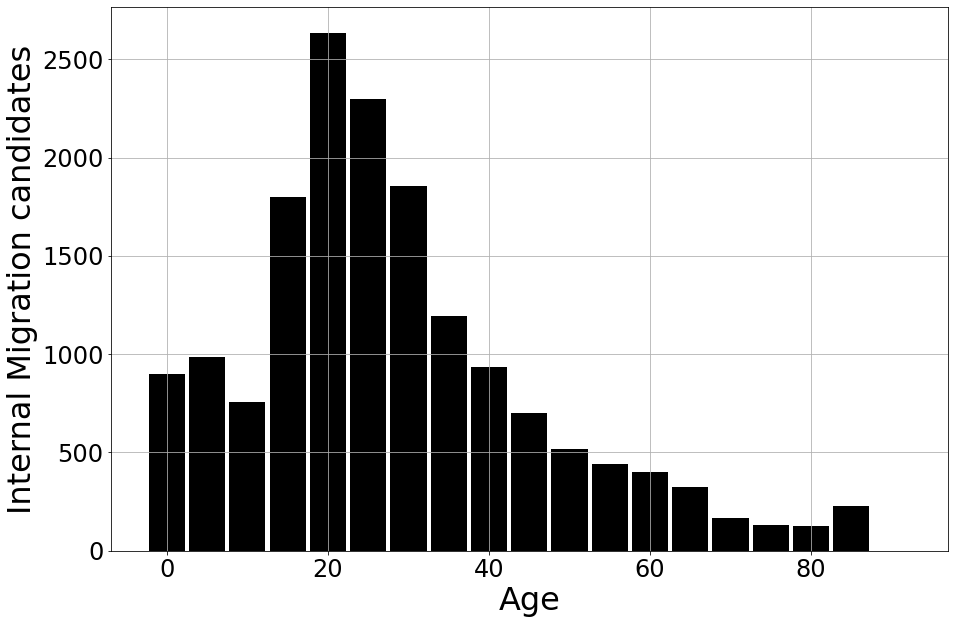

In [14]:
plt.figure(figsize=(15, 10))

migrant_pool["age"].hist(bins=range(0, 100, 5), 
                     rwidth=0.9, 
                     color='k',
                     align='left'
                    )
plt.xlabel("Age", size=32)
plt.ylabel("Internal Migration candidates", size=32)
plt.xticks(size=24)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

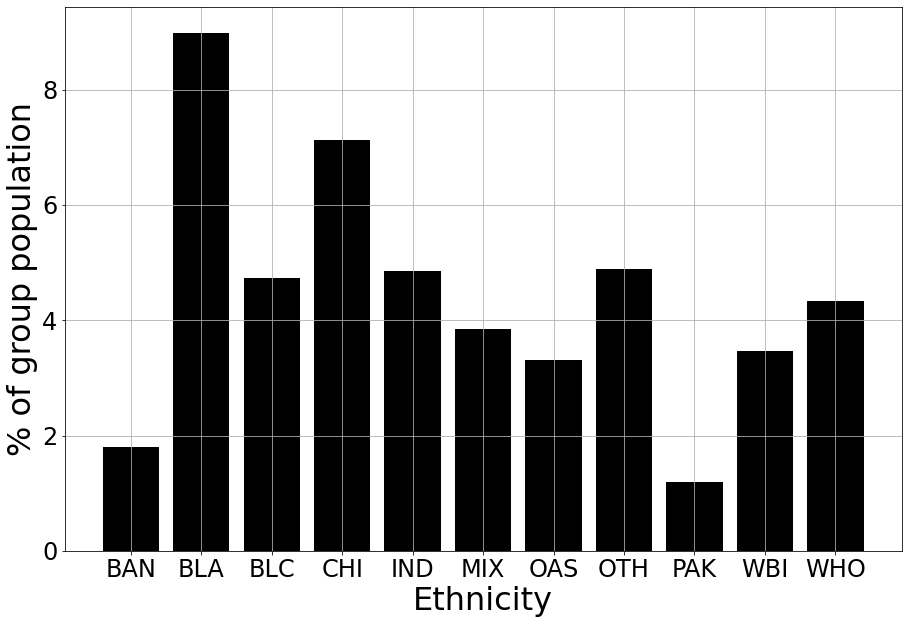

In [15]:
series2plot = migrant_pool['ethnicity'].value_counts() / pop["ethnicity"].value_counts() * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("% of group population", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

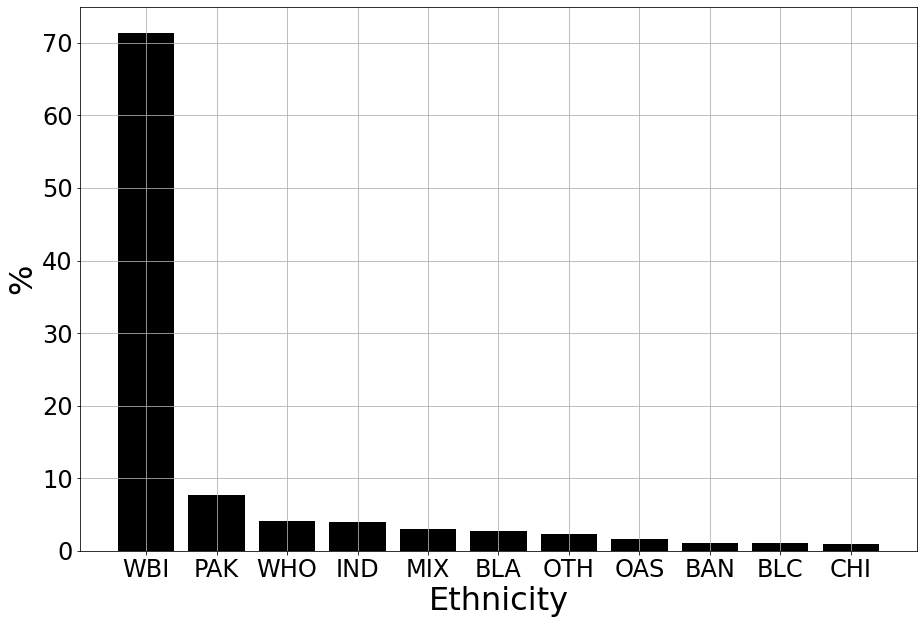

In [16]:
series2plot = migrant_pool['ethnicity'].value_counts() / len(migrant_pool["ethnicity"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

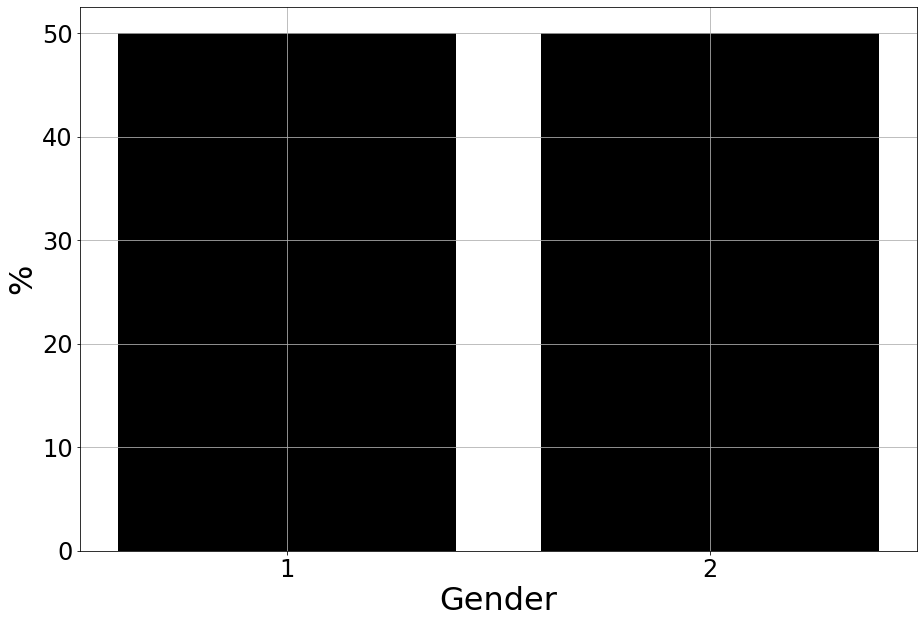

In [17]:
series2plot = migrant_pool['sex'].value_counts() / len(migrant_pool["sex"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Gender", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

/Users/khosseini/myJobs/ATI/Projects/2019/SPENCER/vivarium_public_health_spenser/venv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


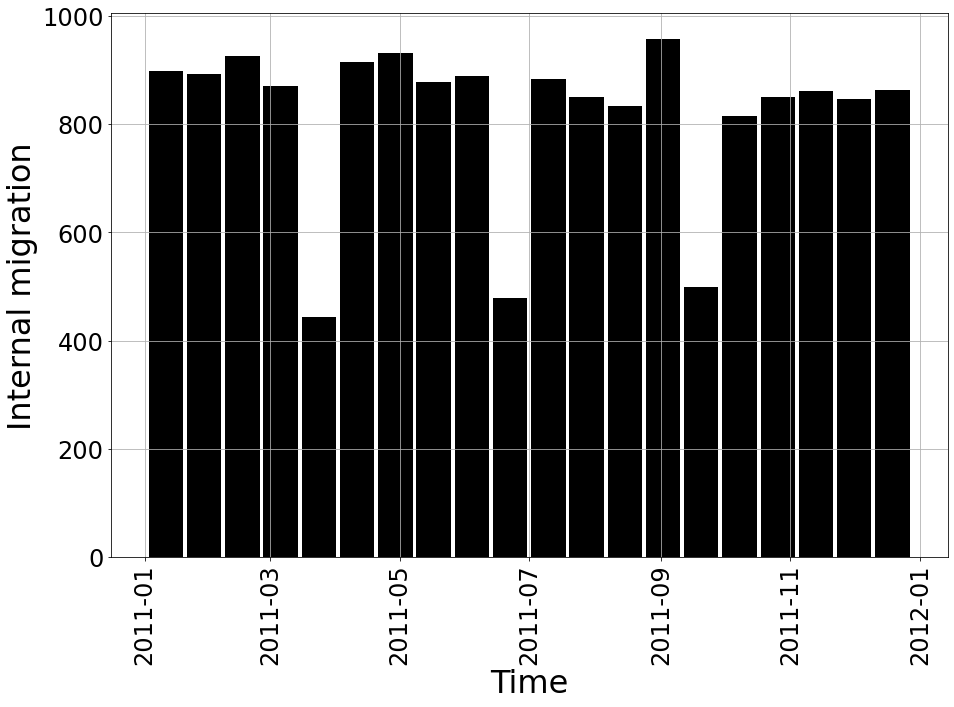

In [18]:
plt.figure(figsize=(15, 10))

migrant_pool["last_outmigration_time"].hist(bins=20, 
                                            rwidth=0.9, 
                                            color='k',
                                            align='left'
                                            )
plt.xlabel("Time", size=32)
plt.ylabel("Internal migration", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

In [19]:
#min_time = pop["entrance_time"].min().strftime("%Y-%m-%d")
min_time = "2011-01-01"
max_time = datetime.datetime.strptime("2011-12-31", "%Y-%m-%d")

print("min_time:", min_time)
print("max_time:", max_time)

min_time: 2011-01-01
max_time: 2011-12-31 00:00:00


In [20]:
# --- input
# intervals for plotting (in days)
interval_in_days = 10
# list of ethnicities
sel_ethnicity = ["WBI", "WHO"]

# Population (total, for selected ethnicities, gender)
total_population = len(pop)
total_population_ETH = len(pop[pop["ethnicity"].isin(sel_ethnicity)])
total_population_male = len(pop[pop["sex"] == 1])
total_population_female = len(pop[pop["sex"] == 2])

time_axis = []
population_axis = []
population_ETH_axis = []
population_M_axis = []
population_F_axis = []

curr_time = datetime.datetime.strptime(min_time, "%Y-%m-%d")
while curr_time <= max_time:
    time_axis.append(curr_time)
    
    # dead population until current time (changes in the while loop)
    pop_dead = pop[pop["last_outmigration_time"] <= curr_time.strftime("%Y-%m-%d")]
    
    num_dead_population = total_population - len(pop_dead)
    population_axis.append(num_dead_population)
    
    num_dead_population_eth = total_population_ETH - len(pop_dead[pop_dead["ethnicity"].isin(sel_ethnicity)])
    population_ETH_axis.append(num_dead_population_eth)
    
    num_dead_male = total_population_male - len(pop_dead[pop_dead["sex"] == 1])
    population_M_axis.append(num_dead_male)
    
    num_dead_female = total_population_female - len(pop_dead[pop_dead["sex"] == 2])
    population_F_axis.append(num_dead_female)
    
    # go to next time, according to the selected interval_in_days
    curr_time = datetime.datetime.strptime(curr_time.strftime("%Y-%m-%d"), "%Y-%m-%d")
    curr_time += datetime.timedelta(days=interval_in_days)

In [21]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

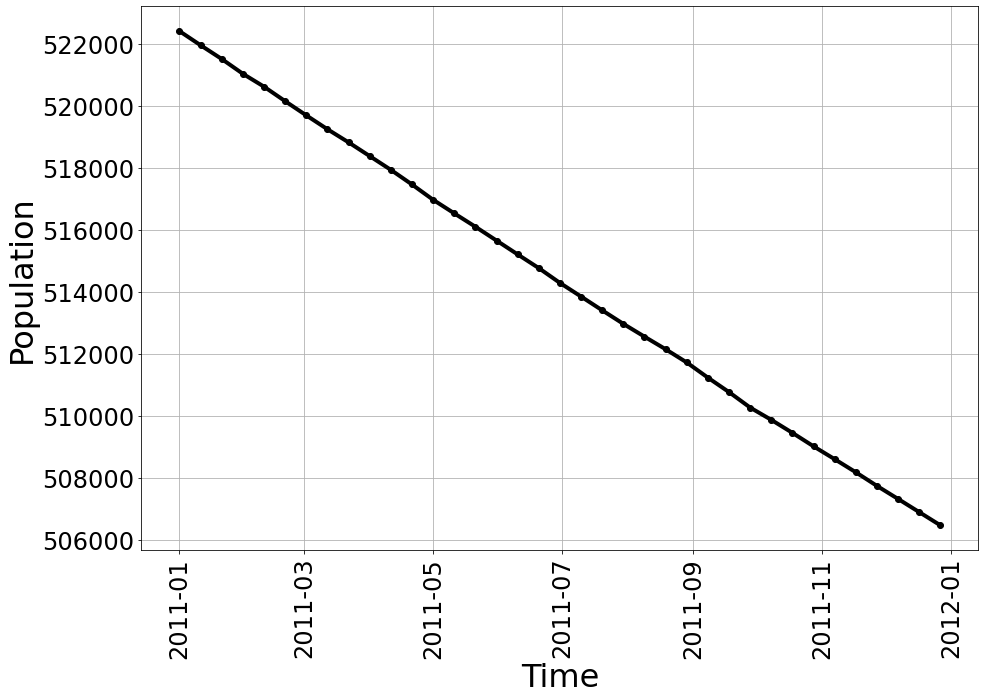

In [22]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_axis, 
         c='k', lw=4, marker="o")
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

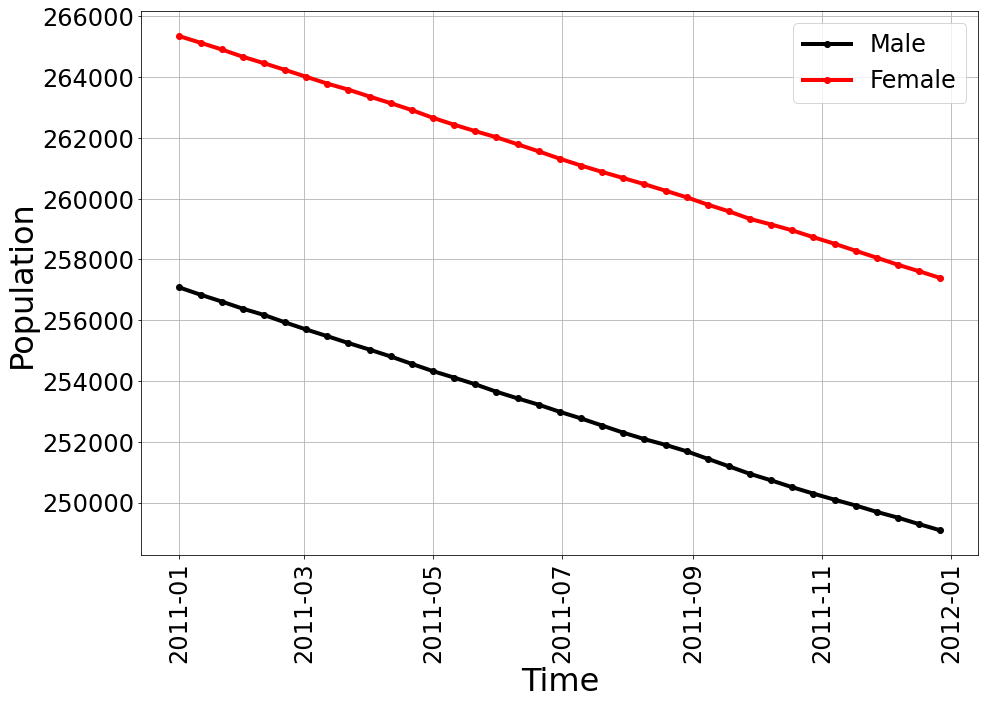

In [23]:
# Population (gender)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_M_axis, 
         c='k', lw=4, marker="o", 
         label="Male"
        )
plt.plot(time_axis, population_F_axis, 
         c='r', lw=4, marker="o",
         label="Female"
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

In [24]:
print(migrant_pool.shape)
migrant_pool.head()

(16386, 13)


,tracked,last_outmigration_time,previous_MSOA_locations,previous_LAD_locations,internal_outmigration,MSOA,ethnicity,alive,age,sex,entrance_time,location,exit_time
12,True,2011-09-08,E02002183,E08000032,Yes,E02002186,WBI,alive,2.013699,1,2010-12-22,E08000032,NaT
41,True,2011-10-28,E02002183,E08000032,Yes,E02002186,WBI,alive,3.013699,1,2010-12-22,E08000032,NaT
54,True,2011-03-22,E02002183,E08000032,Yes,E02002186,WBI,alive,4.013699,1,2010-12-22,E08000032,NaT
83,True,2011-11-27,E02002183,E08000032,Yes,E02002186,WBI,alive,5.013699,1,2010-12-22,E08000032,NaT
102,True,2011-09-18,E02002183,E08000032,Yes,E02002186,WBI,alive,6.013699,1,2010-12-22,E08000032,NaT


## Plot on map

In [25]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pyproj import Transformer

In [26]:
transformer = Transformer.from_crs('EPSG:27700', 'EPSG:4326')

def calcLatLon(row, transformer):
    return transformer.transform(row["X"], row["Y"])

In [27]:
# read centroid file
msoa_centroids = pd.read_csv("../persistant_data/Middle_Layer_Super_Output_Areas__December_2001__Population_Weighted_Centroids.csv")

In [28]:
# Calculate coordinates based on centroid file
msoa_centroids["coord"] = \
        msoa_centroids.apply(calcLatLon, transformer=transformer, axis=1)
msoa_centroids[["lat", "lon"]] = \
        pd.DataFrame(msoa_centroids['coord'].to_list(), columns=["lat", "lon"])

In [29]:
msoa_centroids.head()

,X,Y,objectid,msoa01cd,msoa01nm,coord,lat,lon
0,532458,181630,1,E02000001,City of London 001,"(51.51806856390007, -0.09234820740685304)",51.518069,-0.092348
1,547997,189392,2,E02000002,Barking and Dagenham 001,"(51.583957628785356, 0.13471150340955101)",51.583958,0.134712
2,548377,188094,3,E02000003,Barking and Dagenham 002,"(51.572195177887295, 0.13964420605725175)",51.572195,0.139644
3,550921,186823,4,E02000004,Barking and Dagenham 003,"(51.56010074279055, 0.17577984757488016)",51.560101,0.175780
4,548707,186820,5,E02000005,Barking and Dagenham 004,"(51.56066134179762, 0.1438638317731335)",51.560661,0.143864


In [30]:
migrant_pool[["prev_MSOA_lat", "prev_MSOA_lon"]] = \
            migrant_pool[["previous_MSOA_locations"]].merge(msoa_centroids[["msoa01cd", "lat", "lon"]], 
                                                            left_on="previous_MSOA_locations", 
                                                            right_on="msoa01cd")[["lat", "lon"]]

/Users/khosseini/myJobs/ATI/Projects/2019/SPENCER/vivarium_public_health_spenser/venv/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [31]:
migrant_pool[["MSOA_lat", "MSOA_lon"]] = \
            migrant_pool[["MSOA"]].merge(msoa_centroids[["msoa01cd", "lat", "lon"]], 
                                                         left_on="MSOA", 
                                                         right_on="msoa01cd")[["lat", "lon"]]

In [32]:
migrant_pool.head()

,tracked,last_outmigration_time,previous_MSOA_locations,previous_LAD_locations,internal_outmigration,MSOA,ethnicity,alive,age,sex,entrance_time,location,exit_time,prev_MSOA_lat,prev_MSOA_lon,MSOA_lat,MSOA_lon
12,True,2011-09-08,E02002183,E08000032,Yes,E02002186,WBI,alive,2.013699,1,2010-12-22,E08000032,NaT,53.937269,-1.866894,53.908092,-1.944663
41,True,2011-10-28,E02002183,E08000032,Yes,E02002186,WBI,alive,3.013699,1,2010-12-22,E08000032,NaT,53.937269,-1.866894,53.908092,-1.944663
54,True,2011-03-22,E02002183,E08000032,Yes,E02002186,WBI,alive,4.013699,1,2010-12-22,E08000032,NaT,53.937269,-1.866894,53.908092,-1.944663
83,True,2011-11-27,E02002183,E08000032,Yes,E02002186,WBI,alive,5.013699,1,2010-12-22,E08000032,NaT,53.937269,-1.866894,53.908092,-1.944663
102,True,2011-09-18,E02002183,E08000032,Yes,E02002186,WBI,alive,6.013699,1,2010-12-22,E08000032,NaT,53.937269,-1.866894,53.908092,-1.944663


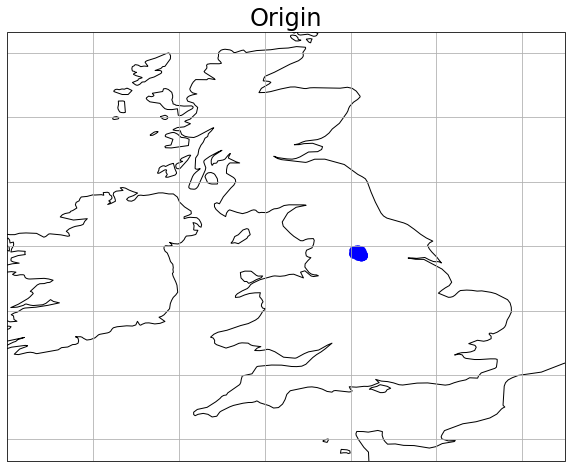

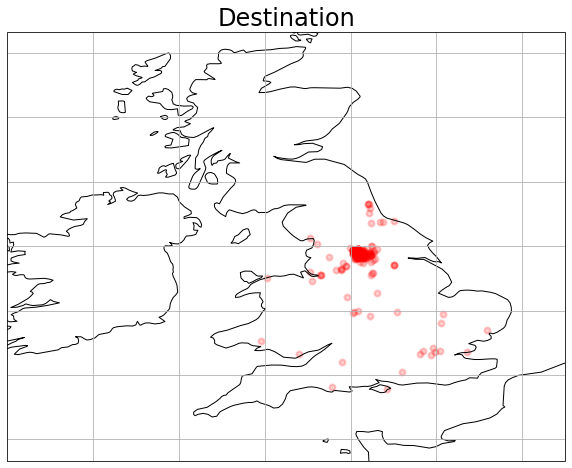

In [33]:
uk_extent = [-10, 3, 49, 59]
plain_crs = ccrs.PlateCarree()

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

ax.scatter(migrant_pool["prev_MSOA_lon"],
           migrant_pool["prev_MSOA_lat"],
           color='blue', linewidth=2, 
           marker='o', alpha=0.2,
           transform=plain_crs)
plt.title("Origin", size=24)

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

ax.scatter(migrant_pool["MSOA_lon"],
           migrant_pool["MSOA_lat"],
           color='red', linewidth=2, 
           marker='o', alpha=0.2,
           transform=plain_crs)
plt.title("Destination", size=24)

plt.show()

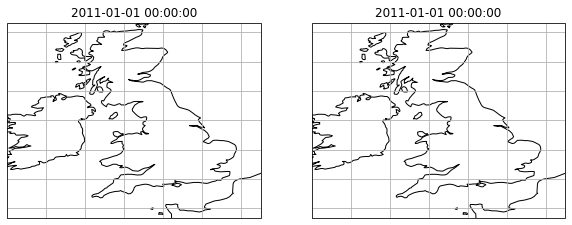

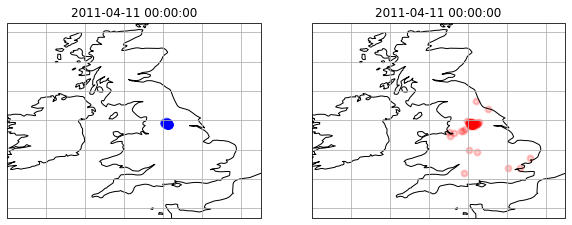

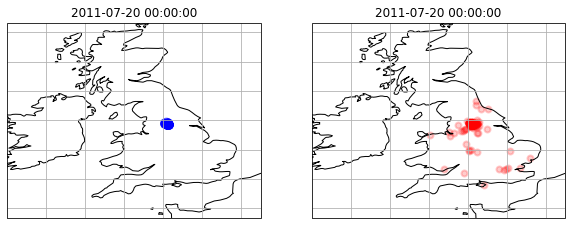

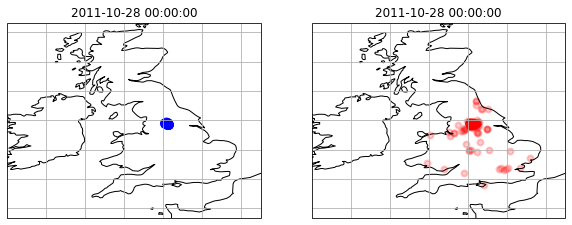

In [34]:
#min_time = pop["entrance_time"].min().strftime("%Y-%m-%d")
min_time = "2011-01-01"
max_time = datetime.datetime.strptime("2011-12-31", "%Y-%m-%d")
uk_extent = [-10, 3, 49, 59]
plain_crs = ccrs.PlateCarree()

# --- input
# intervals for plotting (in days)
interval_in_days = 100
curr_time = datetime.datetime.strptime(min_time, "%Y-%m-%d")

while curr_time <= max_time:
    time_axis.append(curr_time)
    
    # dead population until current time (changes in the while loop)
    migrant_pool_curr = migrant_pool[migrant_pool["last_outmigration_time"] <= curr_time.strftime("%Y-%m-%d")]

    plt.figure(figsize=(10, 20))
    ax = plt.subplot(1, 2, 1, projection=plain_crs)
    ax.coastlines(resolution='50m')
    ax.gridlines()
    ax.set_extent(uk_extent, crs=plain_crs)
    
    ax.scatter(migrant_pool_curr["prev_MSOA_lon"],
           migrant_pool_curr["prev_MSOA_lat"],
           color='blue', linewidth=2, 
           marker='o', alpha=0.2,
           transform=plain_crs)
    plt.title(curr_time)
    
    ax = plt.subplot(1, 2, 2, projection=plain_crs)
    ax.coastlines(resolution='50m')
    ax.gridlines()
    ax.set_extent(uk_extent, crs=plain_crs)
    ax.scatter(migrant_pool_curr["MSOA_lon"],
           migrant_pool_curr["MSOA_lat"],
           color='red', linewidth=2, 
           marker='o', alpha=0.2,
           transform=plain_crs)
    plt.title(curr_time)
    
#     ax.plot([migrant_pool_curr["prev_MSOA_lon"],migrant_pool_curr["MSOA_lon"]], 
#              [migrant_pool_curr["prev_MSOA_lat"],migrant_pool_curr["MSOA_lat"]],
#              color='k', linewidth=2, alpha=0.1,
#              transform=ccrs.Geodetic(),
#              )
    plt.show()
    
    # go to next time, according to the selected interval_in_days
    curr_time = datetime.datetime.strptime(curr_time.strftime("%Y-%m-%d"), "%Y-%m-%d")
    curr_time += datetime.timedelta(days=interval_in_days)

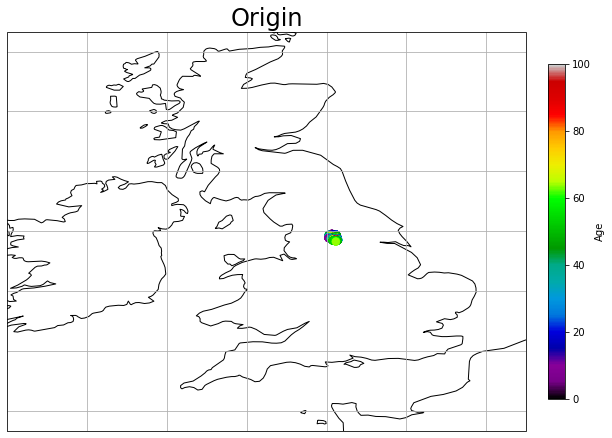

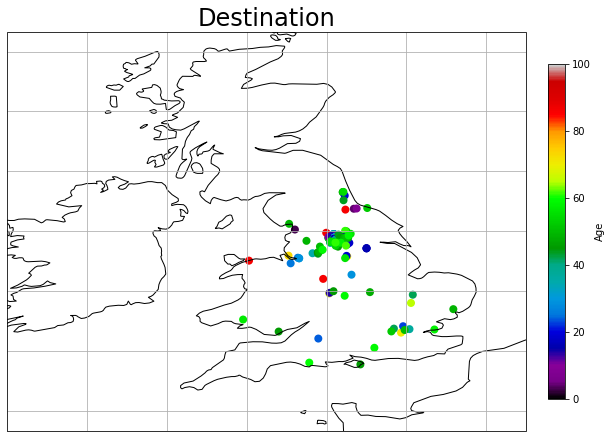

In [35]:
uk_extent = [-10, 3, 49, 59]
plain_crs = ccrs.PlateCarree()
cm = plt.cm.get_cmap('nipy_spectral')

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

sc = ax.scatter(migrant_pool["prev_MSOA_lon"],
           migrant_pool["prev_MSOA_lat"],
           c=migrant_pool["age"], 
           linewidth=2, marker='o',
           cmap=cm,
           vmin=0, vmax=100,
           transform=plain_crs,
           )
cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
cbar.set_label("Age")
plt.title("Origin", size=24)

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

ax.scatter(migrant_pool["MSOA_lon"],
           migrant_pool["MSOA_lat"],
           c=migrant_pool["age"], 
           linewidth=2, marker='o',
           cmap=cm,
           vmin=0, vmax=100,
           transform=plain_crs,
           )
cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
cbar.set_label("Age")
plt.title("Destination", size=24)

plt.show()

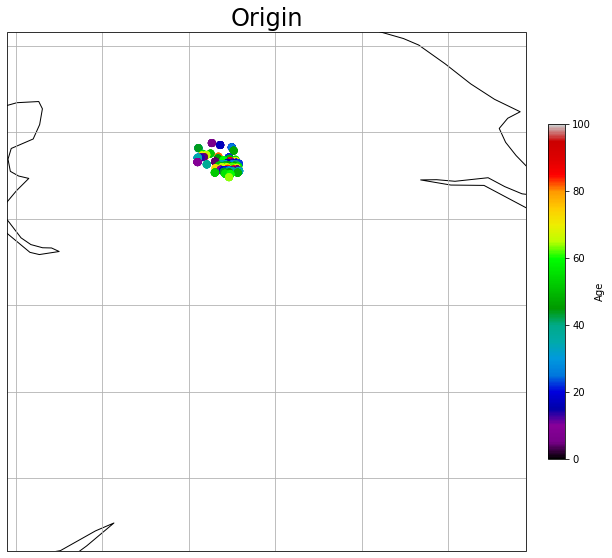

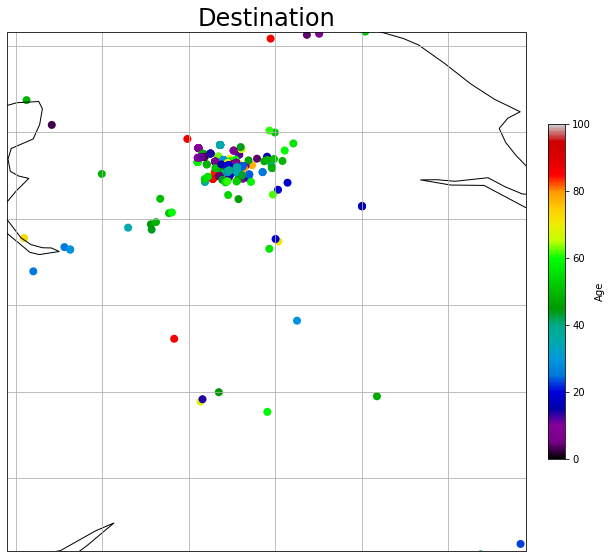

In [36]:
plain_crs = ccrs.PlateCarree()
cm = plt.cm.get_cmap('nipy_spectral')

dx = dy = 1.5
uk_extent = [-1.55-dx, -1.55+dx, 53.08-dy, 53.08+dy]

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

sc = ax.scatter(migrant_pool["prev_MSOA_lon"],
           migrant_pool["prev_MSOA_lat"],
           c=migrant_pool["age"], 
           linewidth=2, marker='o',
           cmap=cm,
           vmin=0, vmax=100,
           transform=plain_crs,
           )
cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
cbar.set_label("Age")
plt.title("Origin", size=24)

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

ax.scatter(migrant_pool["MSOA_lon"],
           migrant_pool["MSOA_lat"],
           c=migrant_pool["age"], 
           linewidth=2, marker='o',
           cmap=cm,
           vmin=0, vmax=100,
           transform=plain_crs,
           )
cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
cbar.set_label("Age")
plt.title("Destination", size=24)

plt.show()

In [37]:
# PLOT on google earth
# installation: 
# !pip install simplekml
# import os
# import simplekml

# # Create an instance of Kml
# kml = simplekml.Kml()

# for index, row in migrant_pool.iterrows():
# #     pnt = kml.newpoint()
# #     pnt.name = str(index)
# #     pnt.coords = [(row["prev_MSOA_lon"],row["prev_MSOA_lat"])]
    
# #     pnt = kml.newpoint()
# #     pnt.name = str(index)
# #     pnt.coords = [(row["MSOA_lon"],row["MSOA_lat"])]
    
#     ls = kml.newlinestring(name='A LineString')
#     ls.coords = [(row["prev_MSOA_lon"],row["prev_MSOA_lat"],50),
#                  (row["MSOA_lon"],row["MSOA_lat"],50)]
#     ls.extrude = 1
#     ls.altitudemode = simplekml.AltitudeMode.clamptoground
#     ls.style.linestyle.width = 1
#     ls.style.linestyle.color = simplekml.Color.red

# # Save the KML
# kml.save("test.kml")